<a href="https://colab.research.google.com/github/Keita-Koyama/q-macro2/blob/main/%E5%BE%8C%E5%8D%8A%E8%AA%B2%E9%A1%8C%E3%80%80%E3%82%B3%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**定量マクロ経済学　後半　最終課題**

問題1


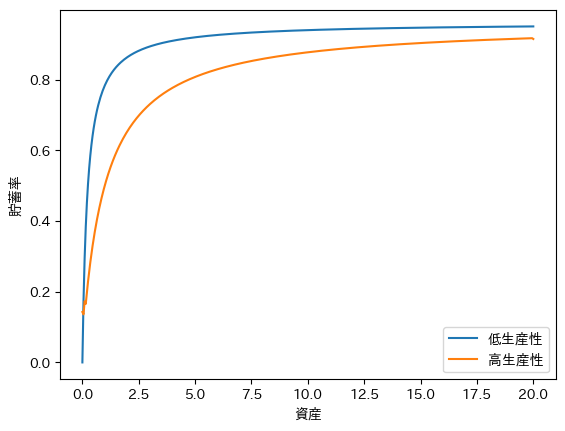

In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import japanize_matplotlib

# マルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(
    sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# 主要変数のプロット
def plot_results(aplus, c, a):
    plt.plot(a, aplus[:, 0] / (c[:, 0] + aplus[:, 0]), label='低生産性')
    plt.plot(a, aplus[:, 1] / (c[:, 1] + aplus[:, 1]), label='高生産性')
    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.legend()
    plt.show()

# パラメータ設定
param = setPar()
# 金利と賃金の設定
r, w = 0.04, 1
# 家計問題の解法
aplus, iaplus, c = solve_household(param, r, w)
# 結果のプロット
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_results(aplus, c, a)


問題2

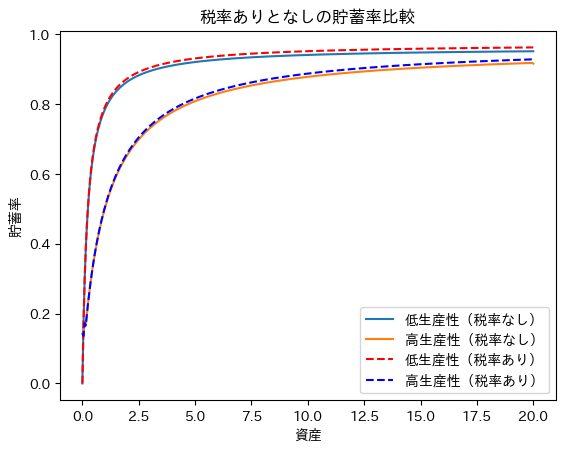

In [48]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# マルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(
    sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法（税率を考慮）
def solve_household_with_tax(param, r, w, tau_k):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + (1.0 - tau_k) * r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + (1.0 - tau_k) * r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# 主要変数のプロット
def plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_tax, c_with_tax, a):
    plt.plot(a, aplus_no_tax[:, 0] / (c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='低生産性（税率なし）')
    plt.plot(a, aplus_no_tax[:, 1] / (c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='高生産性（税率なし）')
    plt.plot(a, aplus_with_tax[:, 0] / (c_with_tax[:, 0] + aplus_with_tax[:, 0]), 'r--', label='低生産性（税率あり）')
    plt.plot(a, aplus_with_tax[:, 1] / (c_with_tax[:, 1] + aplus_with_tax[:, 1]), 'b--', label='高生産性（税率あり）')
    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.title("税率ありとなしの貯蓄率比較")
    plt.legend()
    plt.show()

# パラメータ設定
param = setPar()
# 金利と賃金の設定
r, w = 0.04, 1
tau_k = 0.3

# 家計問題の解法（税率なし）
aplus_no_tax, iaplus_no_tax, c_no_tax = solve_household_with_tax(param, r, w, 0.0)
# 家計問題の解法（税率あり）
aplus_with_tax, iaplus_with_tax, c_with_tax = solve_household_with_tax(param, r, w, tau_k)

# 結果のプロット
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_tax, c_with_tax, a)


問題3

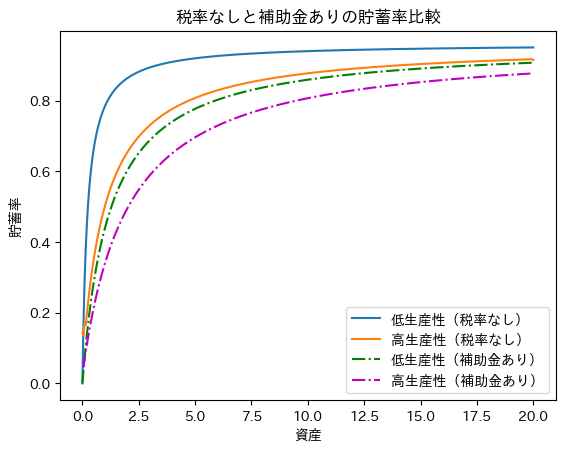

In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import japanize_matplotlib

# マルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(
    sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法（補助金を考慮）
def solve_household_with_transfer(param, r, w, T):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap] + T
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih] + T
    return aplus, iaplus, c

# 主要変数のプロット
def plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_transfer, c_with_transfer, a):
    plt.plot(a, aplus_no_tax[:, 0] / (c_no_tax[:, 0] + aplus_no_tax[:, 0]), label='低生産性（税率なし）')
    plt.plot(a, aplus_no_tax[:, 1] / (c_no_tax[:, 1] + aplus_no_tax[:, 1]), label='高生産性（税率なし）')
    plt.plot(a, aplus_with_transfer[:, 0] / (c_with_transfer[:, 0] + aplus_with_transfer[:, 0]), 'g-.', label='低生産性（補助金あり）')
    plt.plot(a, aplus_with_transfer[:, 1] / (c_with_transfer[:, 1] + aplus_with_transfer[:, 1]), 'm-.', label='高生産性（補助金あり）')
    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.title("税率なしと補助金ありの貯蓄率比較")
    plt.legend()
    plt.show()

# パラメータ設定
param = setPar()
# 金利と賃金の設定
r, w = 0.04, 1
T = 1  # 補助金の額

# 家計問題の解法（税率なし）
aplus_no_tax, iaplus_no_tax, c_no_tax = solve_household_with_transfer(param, r, w, 0.0)
# 家計問題の解法（補助金あり）
aplus_with_transfer, iaplus_with_transfer, c_with_transfer = solve_household_with_transfer(param, r, w, T)

# 結果のプロット
a = np.linspace(param['a_l'], param['a_u'], param['NA'])
plot_combined_results(aplus_no_tax, c_no_tax, aplus_with_transfer, c_with_transfer, a)


問題4

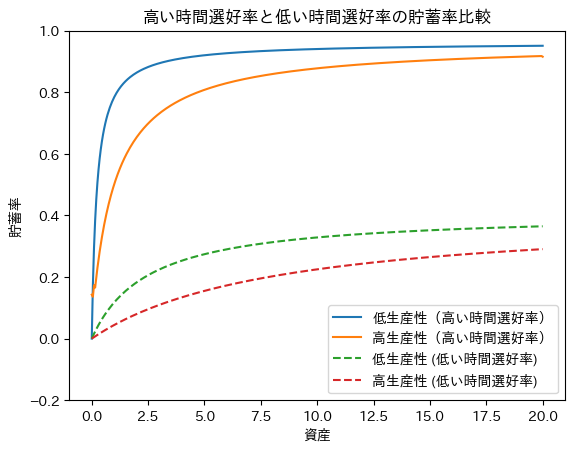

In [53]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import japanize_matplotlib

# マルコフ過程の離散化
def tauchen(n, mu, rho, sigma):
    m = 1 / np.sqrt(1 - rho**2)
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)
    d = (state_space[-1] - state_space[0]) / (n - 1)
    transition_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                transition_matrix[i, j] = norm.cdf((state_space[0] - rho * state_space[i] + d / 2) / sigma)
            elif j == n - 1:
                transition_matrix[i, j] = 1.0 - norm.cdf((state_space[-1] - rho * state_space[i] - d / 2) / sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho * state_space[i] + d / 2) / sigma) - norm.cdf((state_space[j] - rho * state_space[i] - d / 2) / sigma)
    return transition_matrix, state_space

# パラメータ設定
def setPar(sigma=1.5, beta=0.98, rho=0.6, sigma_eps=0.6, a_l=0, a_u=20, NA=401, NH=2, mu_h=-0.7, alpha=0.25, delta=0.03):
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)
    param = {
        'sigma': sigma, 'beta': beta, 'pi': pi, 'h': h, 'NA': NA, 'NH': NH,
        'a_l': a_l, 'a_u': a_u, 'alpha': alpha, 'delta': delta
    }
    return param

# 家計問題の解法
def solve_household(param, r, w):
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    a = np.linspace(a_l, a_u, NA)
    util = np.full((NA, NA, NH), -10000.0)
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w * h[ih] + (1.0 + r) * a[ia] - a[iap]
                if cons > 0:
                    util[iap, ia, ih] = cons**(1.0-sigma) / (1.0-sigma)
    v = np.zeros((NA, NH))
    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    tol = 1e-6
    test = 10.0
    while test > tol:
        for ia in range(NA):
            for ih in range(NH):
                reward = util[:, ia, ih]
                for ihp in range(NH):
                    reward += beta * pi[ih, ihp] * v[:, ihp]
                v_new[ia, ih] = np.max(reward)
                iaplus[ia, ih] = np.argmax(reward)
        test = np.max(np.abs(v_new - v))
        v = v_new
    aplus = a[iaplus]
    c = np.zeros((NA, NH))
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w * h[ih] + (1.0 + r) * a[ia] - aplus[ia, ih]
    return aplus, iaplus, c

# パラメータの設定
sigma = 1.5
beta_low = 0.1  # 低い時間選好率
rho = 0.6
sigma_e = 0.6
r = 0.04
w = 1

# 生産性の設定
h_L = np.exp(-sigma_e)
h_H = np.exp(sigma_e)

# 資産のグリッドを広範囲に設定
a_t_grid = np.linspace(0, 20, 200)

# 貯蓄率の計算（低い時間選好率）
def calc_saving_rate_low_beta(a_t, h):
    c_t = w * h + (1 + r) * a_t - a_t / (1 + beta_low)
    a_t_plus_1 = beta_low * (w * h + (1 + r) * a_t - c_t)
    saving_rate = a_t_plus_1 / (c_t + a_t_plus_1)
    return saving_rate

saving_rate_L_low_beta = [calc_saving_rate_low_beta(a, h_L) for a in a_t_grid]
saving_rate_H_low_beta = [calc_saving_rate_low_beta(a, h_H) for a in a_t_grid]

# 主要変数のプロット
def plot_results(aplus_high, c_high, aplus_low, c_low, a):
    plt.plot(a, aplus_high[:, 0] / (c_high[:, 0] + aplus_high[:, 0]), label='低生産性（高い時間選好率）', linestyle='-')
    plt.plot(a, aplus_high[:, 1] / (c_high[:, 1] + aplus_high[:, 1]), label='高生産性（高い時間選好率）', linestyle='-')
    plt.plot(a_t_grid, saving_rate_L_low_beta, label='低生産性 (低い時間選好率)', linestyle='--')
    plt.plot(a_t_grid, saving_rate_H_low_beta, label='高生産性 (低い時間選好率)', linestyle='--')
    plt.xlabel('現在の資産')
    plt.ylabel('貯蓄率')
    plt.xlabel("資産")
    plt.ylabel("貯蓄率")
    plt.ylim(-0.2, 1.0)
    plt.legend()
    plt.title("高い時間選好率と低い時間選好率の貯蓄率比較")
    plt.gca().set_aspect('auto', adjustable='box')  # 縦横比を調整
    plt.show()

# パラメータ設定（高い時間選好率）
param_high = setPar(beta=0.98)
# パラメータ設定（低い時間選好率）
param_low = setPar(beta=0.1)

# 金利と賃金の設定
r, w = 0.04, 1

# 家計問題の解法（高い時間選好率）
aplus_high, iaplus_high, c_high = solve_household(param_high, r, w)
# 家計問題の解法（低い時間選好率）
aplus_low, iaplus_low, c_low = solve_household(param_low, r, w)

# 結果のプロット
a = np.linspace(param_high['a_l'], param_high['a_u'], param_high['NA'])
plot_results(aplus_high, c_high, aplus_low, c_low, a)
